In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm, tqdm_notebook

In [2]:
import numba
from math import *
import random

In [16]:
x = np.arange(101)

In [17]:
w = 30
p = 0.5 * np.exp(-(x-12)**2/w) + \
    0.8 * np.exp(-(x-37)**2/w) + \
    1.0 * np.exp(-(x-65)**2/w) + \
    0.5 * np.exp(-(x-87)**2/w)
p = p / np.sum(p)

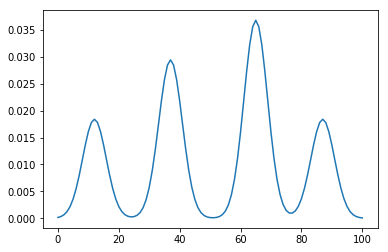

In [18]:
plt.plot(x, p)
plt.show()

In [19]:
U = -np.log(p)

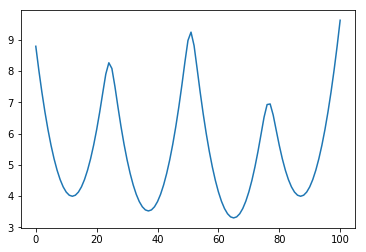

In [21]:
plt.plot(x, U[x])
plt.show()

In [22]:
@numba.jit('f8(f8)', nopython=True)
def potential(x):
    w = 30
    p = 0.5 * exp(-(x-12)**2/w) + \
        0.8 * exp(-(x-37)**2/w) + \
        1.0 * exp(-(x-65)**2/w) + \
        0.5 * exp(-(x-87)**2/w)
    return -log(p)

@numba.jit('f8(f8, f8, f8, f8)', nopython=True)
def new_position(pos, stepsize, min, max):
    direction = 1 if (random.random() > 0.5) else -1
    new_pos = pos + (random.random()*stepsize) * direction
    if new_pos < min or new_pos > max:
        return new_position(pos, stepsize, min, max)
    else:
        return new_pos

@numba.jit('f8[:](f8, i8, i8, f8, f8, f8)', nopython=True)
def run_mc(pos, step, interval, stepsize, min, max):
    pot = potential(pos)
    traj = []
    for i in range(step):
        new_pos = new_position(pos, stepsize, min, max)
        new_pot = potential(new_pos)
        diff = new_pot - pot
        crit = True if diff < 0 or exp(-diff/0.6) > random.random() else False
        if crit:
            pos = new_pos
            pot = new_pot
        if i % interval == 0:
            traj.append(pos)
    return np.array(traj)

class simulation():
    def __init__(self):
        self.traj = []
        self.stepsize = 0.5
        self.boundary = [0, 100]
        self.set_position(0)
        self.interval = 10
    
    def set_position(self, x):
        self.pos = x
        self.pot = potential(x)
        
    def run_mc(self, step):
        traj = run_mc(self.pos, step, self.interval, self.stepsize, self.boundary[0], self.boundary[1])
        self.traj = traj
        self.pos = traj[-1]
        self.pot = potential(self.pos)

In [23]:
%time
s = simulation()
s.run_mc(10000000)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs


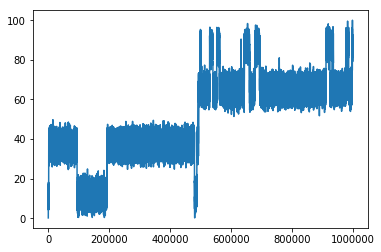

In [24]:
x = range(len(s.traj))
y = s.traj
plt.plot(x, y)

In [29]:
# 10 simulations with nstep=1000000
sims = []
nsim = 10
nstep = 10000
for i in tqdm_notebook(range(nsim)):
    s = simulation()
    s.run_mc(nstep)
    sims.append(s)

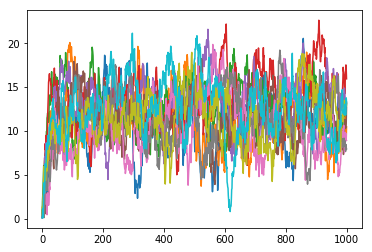

In [30]:
x = range(len(s.traj))
for i in range(nsim):
    y = sims[i].traj
    plt.plot(x, y)

In [31]:
from msmbuilder.msm import MarkovStateModel
from msmbuilder.cluster import RegularSpatial
msm = MarkovStateModel(lag_time=10, n_timescales=10)
traj = [sims[i].traj[np.newaxis, :].T for i in range(nsim)]
cluster = RegularSpatial(d_min=1)

/Users/sunhwan/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/sunhwan/miniconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [32]:
cluster.cluster_centers_.T

AttributeError: 'RegularSpatial' object has no attribute 'cluster_centers_'

In [ ]:
dtraj = cluster.fit_transform(traj)

In [ ]:
msm.fit(dtraj)

In [ ]:
x = cluster.cluster_centers_[msm.state_labels_, 0]
pi = msm.populations_
plt.bar(x, pi)
plt.show()